#ENSIAS 2023
#Socila Network Analysis
#Sentiment Analysis using BERT Darija 
we will try in this notebook to use the data we have already collected in our (souk de entrepreneurs) group
in ordre to predict the sentiments of commenters on the post (positive,negative or neutral)

BERT (Bidirectionnal Encoder Representations for Transformers) is a “new method of pre-training language representations” developed by Google and released in late 2018.

### Import Libraries and Set the intial variables

In [ ]:
!pip install transformers googletrans==3.1.0a0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 58.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 113.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 25.2 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16368 sha256=f8bd4d9a0a435df024a6fb5bda3db87ab9105f3c9d

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import googletrans
from googletrans import Translator
# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from tqdm import *
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
# Misc.
import warnings
warnings.filterwarnings('ignore')

,text,targe
0,بين أستوديوهات ورزازات وصحراء مرزوكة وآثار ولي...,0
1,قررت النجمة الأمريكية أوبرا وينفري ألا يقتصر ع...,0
2,أخبارنا المغربية الوزاني تصوير الشملالي ألهب ا...,0
3,اخبارنا المغربية قال ابراهيم الراشدي محامي سعد...,0
4,تزال صناعة الجلود في المغرب تتبع الطريقة التقل...,0
...,...,...
111723,اللاعب تأخر في العودة إلى التداريب والمدرب غاض...,4
111724,المشرف العام لحسنية أكادير قال إنه سيغادر الفر...,4
111725,نسب إليه نتائج الوداد وصحوة الرجاء وآخر صيحاته...,4
111726,ستحتضن الرباط في الفترة مابين يوليوز المقبل دو...,4


,text,Tag,Topic
0,بين أستوديوهات ورزازات وصحراء مرزوكة وآثار ولي...,0,Colture
1,قررت النجمة الأمريكية أوبرا وينفري ألا يقتصر ع...,0,Colture
2,أخبارنا المغربية الوزاني تصوير الشملالي ألهب ا...,0,Colture
3,اخبارنا المغربية قال ابراهيم الراشدي محامي سعد...,0,Colture
4,تزال صناعة الجلود في المغرب تتبع الطريقة التقل...,0,Colture
...,...,...,...
111723,اللاعب تأخر في العودة إلى التداريب والمدرب غاض...,4,Sport
111724,المشرف العام لحسنية أكادير قال إنه سيغادر الفر...,4,Sport
111725,نسب إليه نتائج الوداد وصحوة الرجاء وآخر صيحاته...,4,Sport
111726,ستحتضن الرباط في الفترة مابين يوليوز المقبل دو...,4,Sport


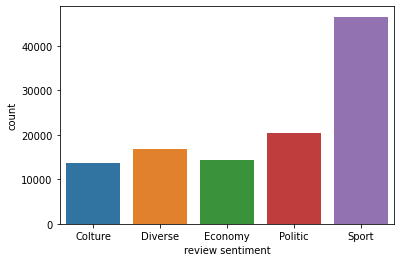

In [ ]:
df = pd.read_csv('arabic_dataset_classifiction.csv')
# Plot the distribution
# class_names = ['negative', 'neutral', 'positive']
# 2=economy  3=politic 4=sport 0=colture 1=diverse
display(df)
conditions = [df['targe'].eq(0),df['targe'].eq(1),df['targe'].eq(2),df['targe'].eq(3),df['targe'].eq(4)]
class_names = ['Colture','Diverse','Economy','Politic','Sport']
df['Topic'] = np.select(conditions, class_names, default=0)
ax = sns.countplot(df.targe)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)
df.columns=('text','Tag','Topic')
display(df)
# display(df[df['Tag']==4])
# df.to_json('Topicmodeling.json')


,text,Tag,Topic
0,بين أستوديوهات ورزازات وصحراء مرزوكة وآثار ولي...,0,Colture
1,قررت النجمة الأمريكية أوبرا وينفري ألا يقتصر ع...,0,Colture
2,أخبارنا المغربية الوزاني تصوير الشملالي ألهب ا...,0,Colture
3,اخبارنا المغربية قال ابراهيم الراشدي محامي سعد...,0,Colture
4,تزال صناعة الجلود في المغرب تتبع الطريقة التقل...,0,Colture
...,...,...,...
84996,NaN,4,Sport
84997,جمعية سلا يدافع عن موقعه أمام اتحاد تمارة في ب...,4,Sport
84998,أعاد سقوط الكامروني عيسى حياتو في انتخابات رئا...,4,Sport
84999,فاز بلقب الخريف بفضل السرعة النهائية ونال كأس ...,4,Sport


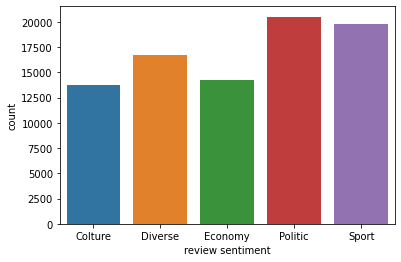

In [ ]:
# print(df[df.index>65000].index)
df.drop(index=(df[df.index>85000].index),inplace=True)
ax = sns.countplot(df.Topic)
plt.xlabel('review sentiment')
display(df)

In [ ]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'
# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load the data

In [ ]:
posts=pd.read_json('data.json')
h=1
comments=[]
comment_id=[]
for i,row in posts.iterrows():
  if posts['commenters_id'][i]!='no comment':
    for j in range(len(row['comments_full'])):
        k=row['comments_full'][j]
        comments.append(k['comment_text'])
        comment_id.append(k['comment_id'])
        for l in range(len(k['replies'])):
          comments.append(k['replies'][l]['comment_text'])
          comment_id.append(k['replies'][l]['comment_id'])
          # print(k['replies'][l]['comment_text'])
          # print(k['comment_text'])
print(comments)
comments=pd.DataFrame(comments)
comments.columns=['text']
comment_id=pd.DataFrame(comment_id)
comment_id.columns=['comment_id']
result = comments.join(comment_id)
display(comments)
display(comment_id)
display(result)

['👏👏👏', 'وأنا عجبتني غير لحطة ديال طويكية اما المقاولة الاجتماعية عندك فيها الصح', 'Jamal Eddine Boukar\nلحطة ديال طويكية تدل على عدم الرضى و choc ديالي', 'Hassan Imad يكون خير خويا حسن\nالتغيير صعيب لاسيما ملي تتخدم على راسك مزيان وتطلع نسبة الوعي لدرجة تتجاوز درجة وعي المجتمع\nإنها بداية التحدي الحقيقي في مواكبة العقليات في نسق نمطي يريد التغيير بشرط عدم المساس للمصالح المتوارتة', 'Jamal Eddine Boukar\nأكيد أخي العزيز', 'Mr. TOBIGO', 'Kamal Mar ماعندي ماتسالك قشعتيه', 'Mnawer ssi Hassan', 'Kolchi ala tarbouch alhaj hhhh nadi', 'Anouar Ait Raho wa tarbouch ghadi yet9ad 😆', 'Myriem Kabbaj Youssef Chakroun', "Hassan Imad En plus de mon commentaire sur ton profil perso, voici quelques liens qui peuvent être utiles pour les personnes intéressées par l'Entrepreneuri\nat social au Maroc (je fais de la pub pour mes rapports 😛 ): https://\nwww.britishcounc\nil.org/sites/\ndefault/files/\nsocial_enterpris\ne_landscape_in_\nmorocco.pdf", 'A study of the social entrepreneurshi\np ecosystem in Mo

,text
0,👏👏👏
1,وأنا عجبتني غير لحطة ديال طويكية اما المقاولة ...
2,Jamal Eddine Boukar\nلحطة ديال طويكية تدل على ...
3,Hassan Imad يكون خير خويا حسن\nالتغيير صعيب لا...
4,Jamal Eddine Boukar\nأكيد أخي العزيز
...,...
1043,ربما الفروع في اماكن استرتيجية او اول مرة تصل ...
1044,كيفاش شراو منها الفرونشيز وهي كتحقق خسائر؟\nوك...
1045,مهتم
1046,علاقة مع زبناء


,comment_id
0,5379722945430910
1,5599884196748116
2,5599909776745558
3,5599915726744963
4,5599919180077951
...,...
1043,5136830149720192
1044,5137597046310169
1045,5137898339613373
1046,5137470079656199


,text,comment_id
0,👏👏👏,5379722945430910
1,وأنا عجبتني غير لحطة ديال طويكية اما المقاولة ...,5599884196748116
2,Jamal Eddine Boukar\nلحطة ديال طويكية تدل على ...,5599909776745558
3,Hassan Imad يكون خير خويا حسن\nالتغيير صعيب لا...,5599915726744963
4,Jamal Eddine Boukar\nأكيد أخي العزيز,5599919180077951
...,...,...
1043,ربما الفروع في اماكن استرتيجية او اول مرة تصل ...,5136830149720192
1044,كيفاش شراو منها الفرونشيز وهي كتحقق خسائر؟\nوك...,5137597046310169
1045,مهتم,5137898339613373
1046,علاقة مع زبناء,5137470079656199


We can see that the most relevant column for us is content and replyContent and the score as well.

In [ ]:
# Let's check for missing values 
df.isnull().sum()

text     708
Tag        0
Topic      0
dtype: int64

[Text(0, 0, 'Colture'),
 Text(0, 0, 'Diverse'),
 Text(0, 0, 'Economy'),
 Text(0, 0, 'Politic'),
 Text(0, 0, 'Sport')]

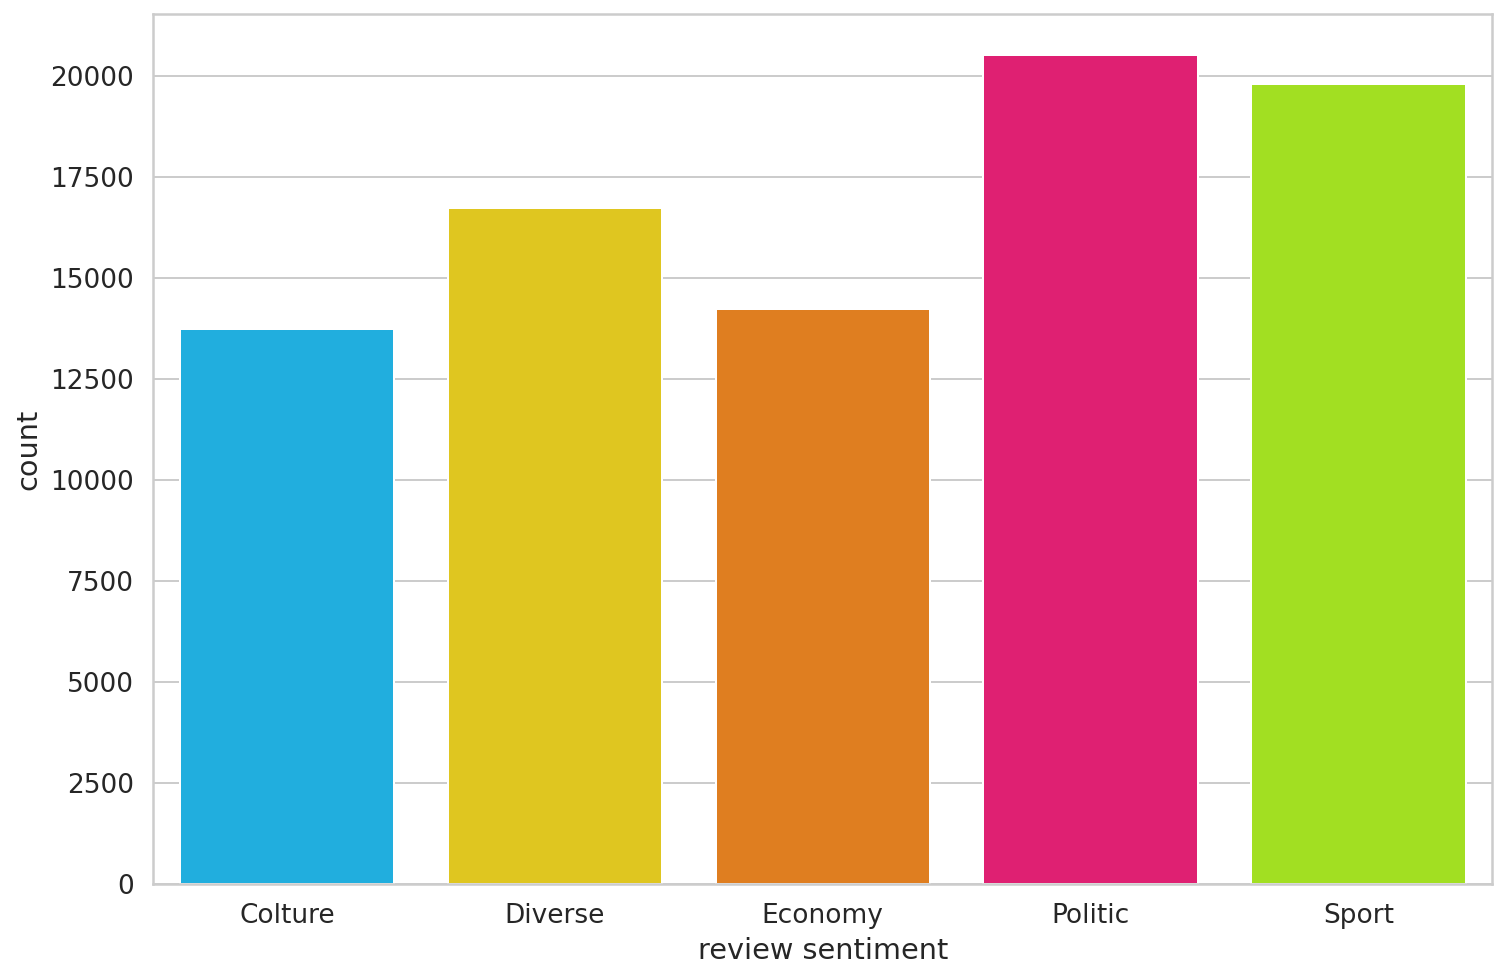

In [ ]:
# Plot the distribution
class_names = ['Colture', 'Diverse', 'Economy', 'Politic', 'Sport']
# class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.Tag)
df['sentiment']=df['Tag']
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

## Data Preprocessing

Machine Learning models don’t work with raw text. You need to convert text to numerical representation. BERT requires even more attention when it comes to this representation. 

Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

BERT offers a few model architectures and I will be using one of them combined with manual preprocessing. I am using the cased version which considers GREAT and great to be to different entities and BAD might be given more focus than bad.  

The tokenizer will break the sentence into words and give numerical values to each word. 

In [ ]:
# Set the model name
# MODEL_NAME = 'bert-base-cased'
# MODEL_NAME ='aubmindlab/bert-base-arabertv02'
MODEL_NAME='SI2M-Lab/DarijaBERT'
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("SI2M-Lab/DarijaBERT")
bert_model = AutoModel.from_pretrained("SI2M-Lab/DarijaBERT")
# Build a BERT based tokenizer
# tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/307 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Downloading:   0%|          | 0.00/879k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Downloading:   0%|          | 0.00/836M [00:00<?, ?B/s]

Some weights of the model checkpoint at SI2M-Lab/DarijaBERT were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You

In [ ]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 3
[CLS] 2
[PAD] 0
[UNK] 1


In [ ]:
import re
import string
# ''''`÷×؛ç<>_()*&^%][ـ،/:"؟.,'{}~ ⃣¦+éèûà([@A-Za-z0-9_]+)|[^\w\s]|#|http\S+\n0123456789''''
arabic_punctuations = '''`•²÷×؛’ôâêâ«»<>()*&^%]î€[ـ،/:"؟.,|!”…“–ـ﷿🤔'{}~¦œ+|!”…“–ـ🤔éèûà([@A-Za-z0-9_]+)|[^\w\s]|#|http\S+\n0123456789'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
emojis = re.compile(pattern = "["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"  
                           "]+", flags = re.UNICODE)


def all_pre(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("_"," ", text)
    text = re.sub("گ", "ك", text)
    text = re.sub(r'[a-z]','', text.lower())
    text = re.sub(arabic_diacritics, '', text)
    # text = re.sub(r'(.)\1+', r'\1', text)
    translator = str.maketrans('', '', punctuations_list)
    text = text.translate(translator)
    text = emojis.sub(r'',text)
    return text
    

In [ ]:
df.replace(' ', np.nan, inplace=True)
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)
# df.drop('Unnamed: 0',axis=1,inplace=True)
display(df)
# df.to_json('predarija.json')

,text,Tag,Topic,sentiment
0,بين أستوديوهات ورزازات وصحراء مرزوكة وآثار ولي...,0,Colture,0
1,قررت النجمة الأمريكية أوبرا وينفري ألا يقتصر ع...,0,Colture,0
2,أخبارنا المغربية الوزاني تصوير الشملالي ألهب ا...,0,Colture,0
3,اخبارنا المغربية قال ابراهيم الراشدي محامي سعد...,0,Colture,0
4,تزال صناعة الجلود في المغرب تتبع الطريقة التقل...,0,Colture,0
...,...,...,...,...
84288,يحاول عضو نافذ داخل المكتب المسير للوداد الريا...,4,Sport,4
84289,جمعية سلا يدافع عن موقعه أمام اتحاد تمارة في ب...,4,Sport,4
84290,أعاد سقوط الكامروني عيسى حياتو في انتخابات رئا...,4,Sport,4
84291,فاز بلقب الخريف بفضل السرعة النهائية ونال كأس ...,4,Sport,4


In [ ]:
for i,row in df.iterrows():
  # print(any(c.isalpha() for c in df['Twits'][i]))
  if re.search('[a-zA-Z]', df['text'][i])!=None:
    translator = Translator()
    translated = translator.translate(row['text'], dest='arabic')
    # print(df['Twits'][i])

In [ ]:
for i,row in df.iterrows():
    df['text'][i]=all_pre(row['text'])
display(df) 
# for i,row in df.iterrows():
#     df['Twits'][i]=all_pre(row['Twits'])
# display(df)    


,text,Tag,Topic,sentiment
0,بين استوديوهات ورزازات وصحراء مرزوكه واثار ولي...,0,Colture,0
1,قررت النجمه الامريكيه اوبرا وينفري الا يقتصر ع...,0,Colture,0
2,اخبارنا المغربيه الوزاني تصوير الشملالي الهب ا...,0,Colture,0
3,اخبارنا المغربيه قال ابراهيم الراشدي محامي سعد...,0,Colture,0
4,تزال صناعه الجلود في المغرب تتبع الطريقه التقل...,0,Colture,0
...,...,...,...,...
84288,يحاول عضو نافذ داخل المكتب المسير للوداد الريا...,4,Sport,4
84289,جمعيه سلا يدافع عن موقعه امام اتحاد تماره في ب...,4,Sport,4
84290,اعاد سقوط الكامروني عيسي حياتو في انتخابات رءا...,4,Sport,4
84291,فاز بلقب الخريف بفضل السرعه النهاءيه ونال كاس ...,4,Sport,4


In [ ]:
display(df)
for i ,row in df.iterrows():
  if not any(c.isalpha() for c in df['text'][i]):
    df=df.drop(i)
df.reset_index(inplace=True,drop=True)
display(df)

,text,Tag,Topic,sentiment
0,بين استوديوهات ورزازات وصحراء مرزوكه واثار ولي...,0,Colture,0
1,قررت النجمه الامريكيه اوبرا وينفري الا يقتصر ع...,0,Colture,0
2,اخبارنا المغربيه الوزاني تصوير الشملالي الهب ا...,0,Colture,0
3,اخبارنا المغربيه قال ابراهيم الراشدي محامي سعد...,0,Colture,0
4,تزال صناعه الجلود في المغرب تتبع الطريقه التقل...,0,Colture,0
...,...,...,...,...
84288,يحاول عضو نافذ داخل المكتب المسير للوداد الريا...,4,Sport,4
84289,جمعيه سلا يدافع عن موقعه امام اتحاد تماره في ب...,4,Sport,4
84290,اعاد سقوط الكامروني عيسي حياتو في انتخابات رءا...,4,Sport,4
84291,فاز بلقب الخريف بفضل السرعه النهاءيه ونال كاس ...,4,Sport,4


,text,Tag,Topic,sentiment
0,بين استوديوهات ورزازات وصحراء مرزوكه واثار ولي...,0,Colture,0
1,قررت النجمه الامريكيه اوبرا وينفري الا يقتصر ع...,0,Colture,0
2,اخبارنا المغربيه الوزاني تصوير الشملالي الهب ا...,0,Colture,0
3,اخبارنا المغربيه قال ابراهيم الراشدي محامي سعد...,0,Colture,0
4,تزال صناعه الجلود في المغرب تتبع الطريقه التقل...,0,Colture,0
...,...,...,...,...
84288,يحاول عضو نافذ داخل المكتب المسير للوداد الريا...,4,Sport,4
84289,جمعيه سلا يدافع عن موقعه امام اتحاد تماره في ب...,4,Sport,4
84290,اعاد سقوط الكامروني عيسي حياتو في انتخابات رءا...,4,Sport,4
84291,فاز بلقب الخريف بفضل السرعه النهاءيه ونال كاس ...,4,Sport,4


In [ ]:
# Store length of each review 
token_lens = []
for txt in df.text:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

Text(0.5, 0, 'Token count')

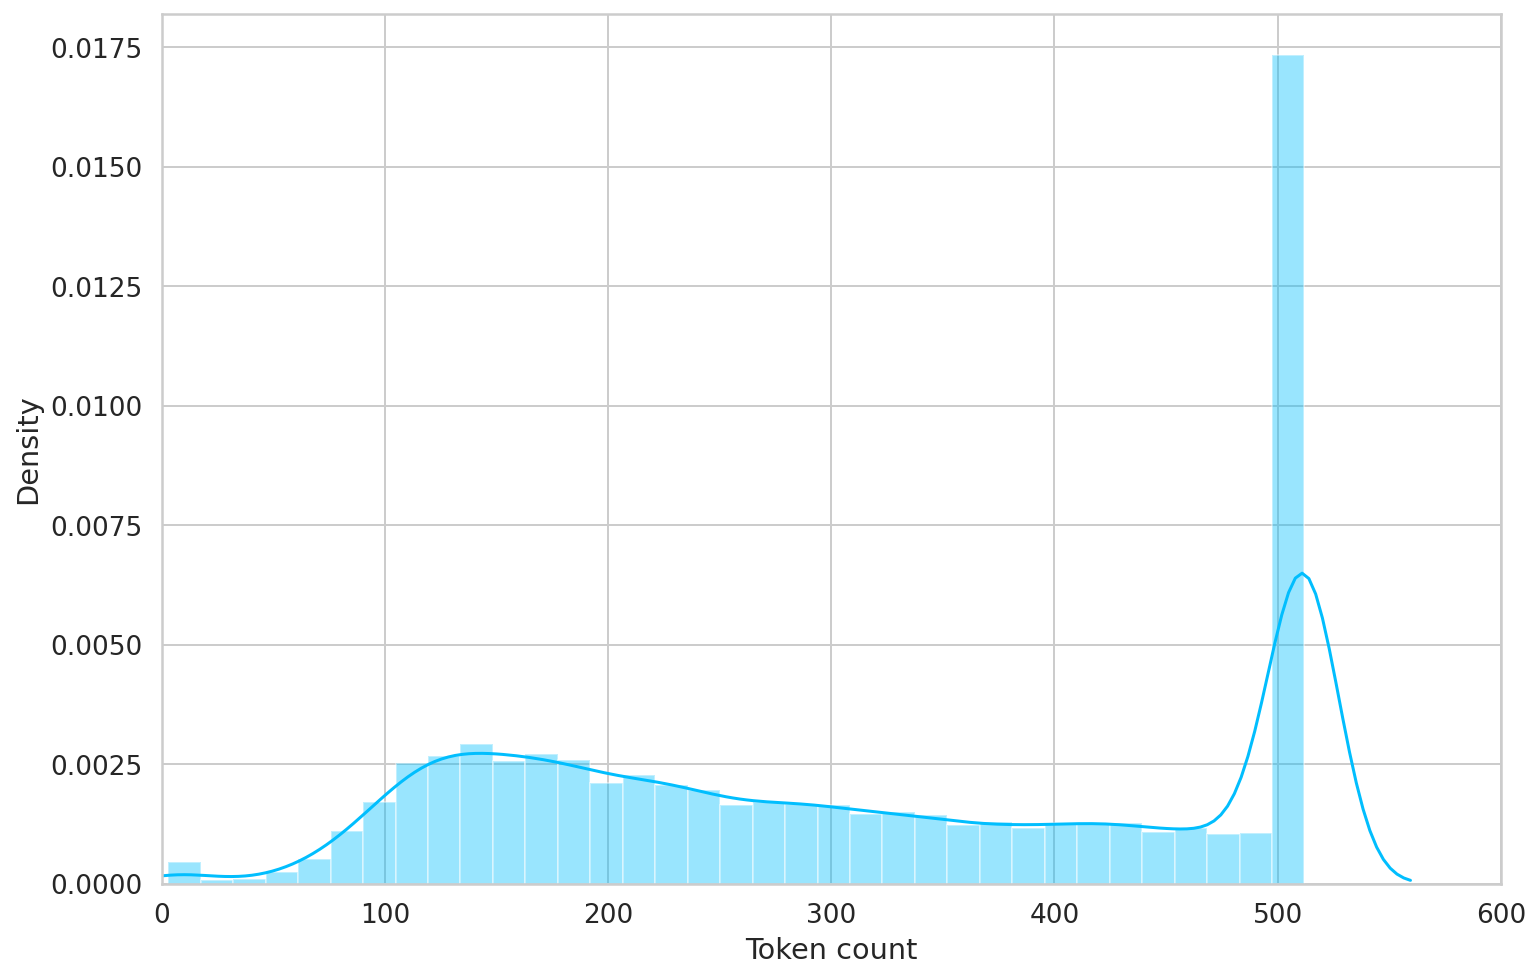

In [ ]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 600]);
plt.xlabel('Token count')

Most of the reviews seem to contain less than 120 tokens, but we’ll be on the safe side and choose a maximum length of 160. 

In [ ]:
MAX_LEN = 512

### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily. 

In [ ]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

**Create** a 80% train data and 10% test and 10% validation data

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(67434, 4) (8429, 4) (8430, 4)


Create a dataloader to release data in batches.

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        # reviews=df.Twits.to_numpy(),
        reviews=df.text.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [ ]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)
# bert_model = AutoModel.from_pretrained("SI2M-Lab/DarijaBERT")


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Some weights of the model checkpoint at SI2M-Lab/DarijaBERT were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not 

In [ ]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        # self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask ,return_dict=False):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [ ]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Some weights of the model checkpoint at SI2M-Lab/DarijaBERT were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not 

#### Model Characterstics

In [ ]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


### Training Phase

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [ ]:
# Number of iterations 
EPOCHS = 1

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

Write a function to evaluate model performance

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                return_dict=False
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

Write the training Loop and store the best training state.

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss) 

Epoch 1/1
----------


100%|██████████| 4215/4215 [1:44:01<00:00,  1.48s/it]


Train loss 0.22437798509817275 accuracy 0.9345434054038022
Val   loss 0.17990363187437605 accuracy 0.9434096571360778

CPU times: user 1h 47min 45s, sys: 59.9 s, total: 1h 48min 45s
Wall time: 1h 48min 42s


The above took a lot of time but it's finally working. Now, we can plot the training and validation accuracy.

### Model Evaluation

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9492289442467378

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     Colture       0.96      0.95      0.96      1358
     Diverse       0.97      0.97      0.97      1692
     Economy       0.91      0.94      0.92      1454
     Politic       0.92      0.91      0.92      1977
       Sport       0.98      0.99      0.98      1949

    accuracy                           0.95      8430
   macro avg       0.95      0.95      0.95      8430
weighted avg       0.95      0.95      0.95      8430



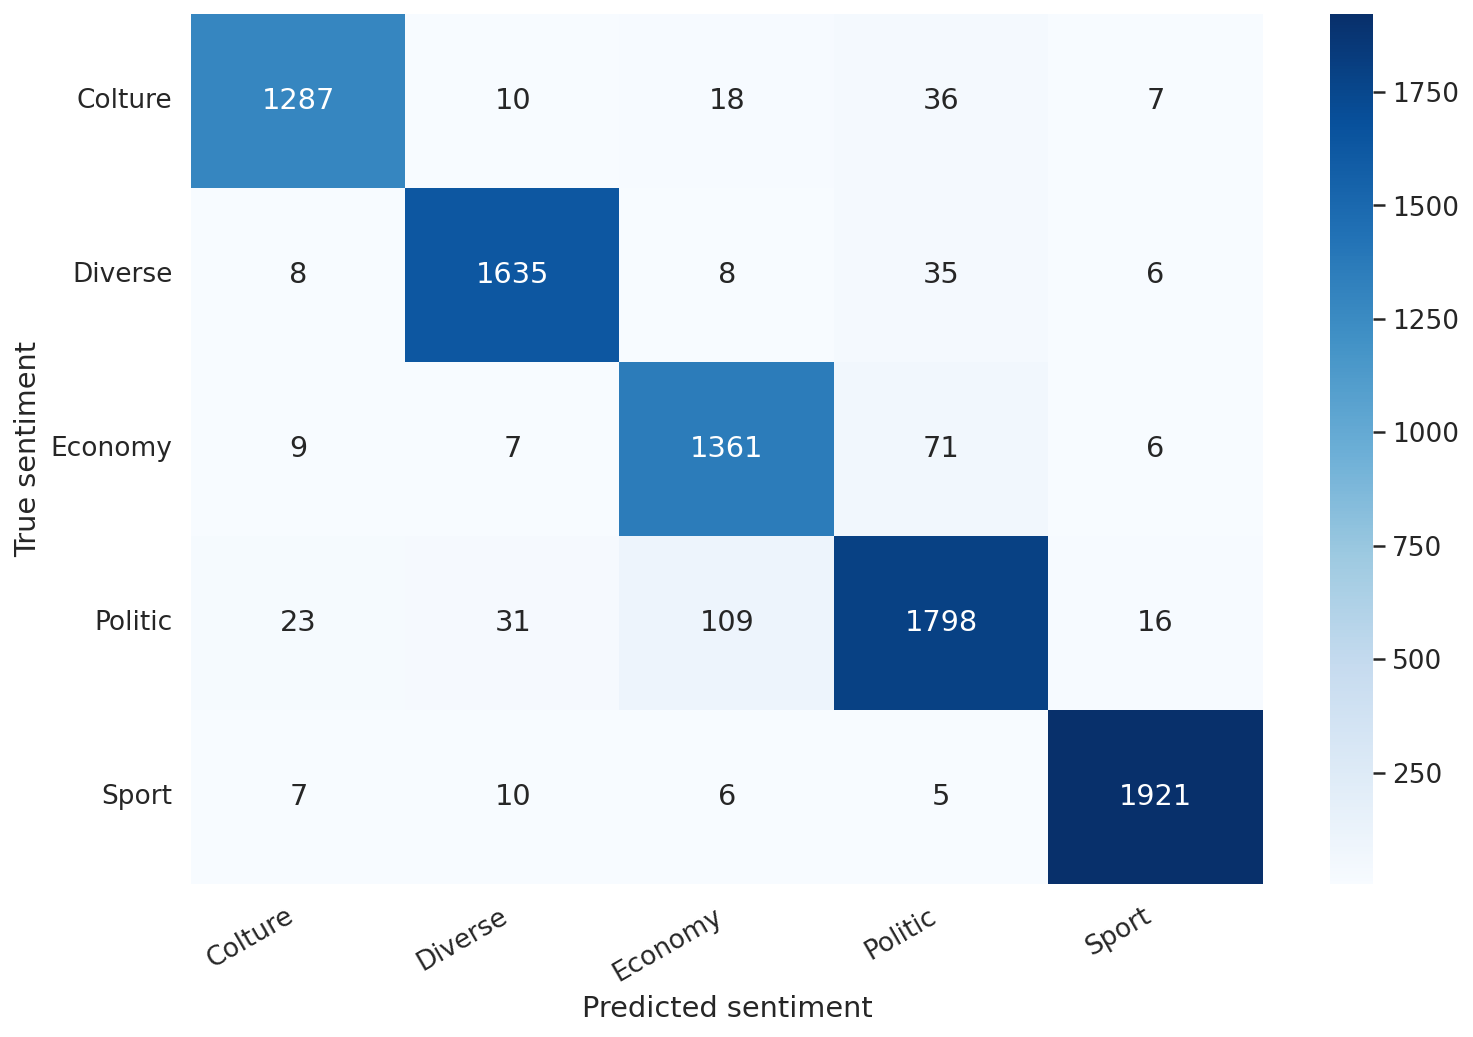

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model.

## Predicting on raw text

In [ ]:
import googletrans
from googletrans import Translator

df1=pd.read_json('data.json')
df1=pd.DataFrame(df1['text'])
# df1=result
for i ,row in df1.iterrows():
  translator = Translator()
  translated = translator.translate(row['text'], dest='arabic')
  df1['text'][i]=translated.text
for i ,row in df1.iterrows():
  
  df1['text'][i]=all_pre((row['text']))
#   print(tokenizer.convert_ids_to_tokens(tokenizer.encode(df['text'][i])))
df1.replace(' ', np.nan, inplace=True)
df1.replace('', np.nan, inplace=True)
df1.dropna(inplace=True)
df1.reset_index(inplace=True,drop=True)
display(df1)

,text
0,اول حاجه كنبغي نقول سنه سعيده لي كملت السنه...
1,لي عنده شي زهر مشروع المشروعالمهم جربو زهركمال...
2,الحاضنه الافريقيه الفرنكوفونيه حديث ملهم رقم ...
3,المقاوله الاجتماعيه واحد المفهوم قليل لي تيعرف...
4,البريد بنك ينظم دورات تكوينيه مجانيه لفاءده ال...
...,...
415,عندما تود التفكير في اخذ مشروعك الي العالميه ...
416,بدء التشغيل الافريقيتطوير حلول مبتكره لتقريب م...
417,‏شركه مطاعم تبيع رخص فرنشايزالفروع الممنوحه تح...
418,الناس ديال جهه مراكش اسفيلمساعدتك في بناء مشرو...


In [ ]:
df1['prediction']=0
for i , row in df1.iterrows():
  review_text=row['text']
  encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',)
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  df1['prediction'][i]=class_names[prediction]

In [ ]:
display(df1)

,text,prediction
0,اول حاجه كنبغي نقول سنه سعيده لي كملت السنه...,Economy
1,لي عنده شي زهر مشروع المشروعالمهم جربو زهركمال...,Economy
2,الحاضنه الافريقيه الفرنكوفونيه حديث ملهم رقم ...,Colture
3,المقاوله الاجتماعيه واحد المفهوم قليل لي تيعرف...,Economy
4,البريد بنك ينظم دورات تكوينيه مجانيه لفاءده ال...,Economy
...,...,...
415,عندما تود التفكير في اخذ مشروعك الي العالميه ...,Economy
416,بدء التشغيل الافريقيتطوير حلول مبتكره لتقريب م...,Economy
417,‏شركه مطاعم تبيع رخص فرنشايزالفروع الممنوحه تح...,Economy
418,الناس ديال جهه مراكش اسفيلمساعدتك في بناء مشرو...,Economy


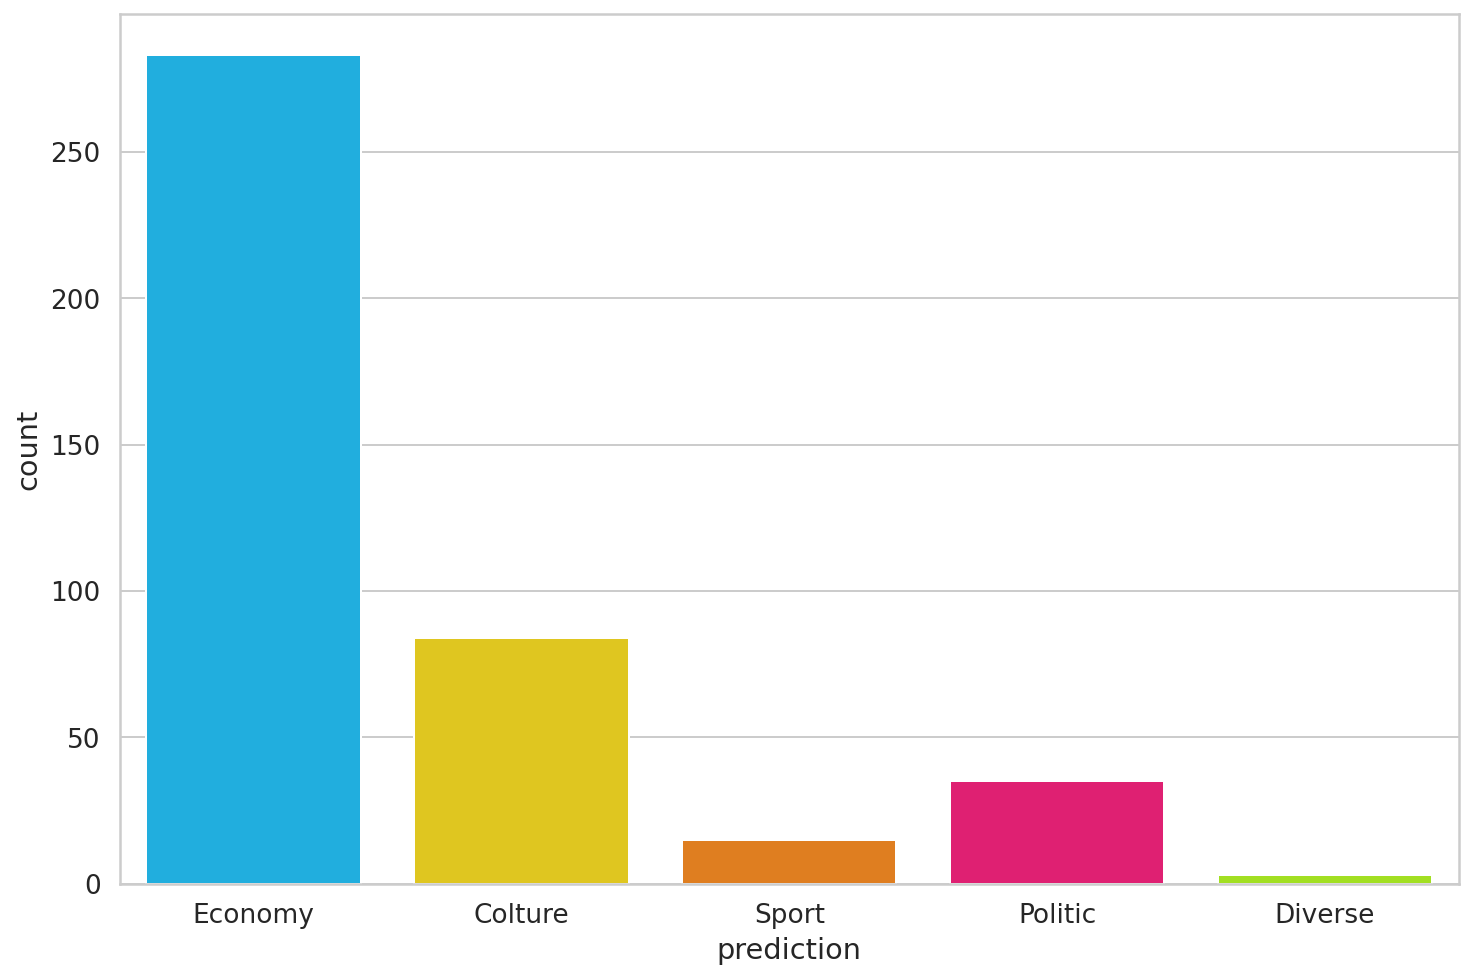

In [ ]:
ax = sns.countplot(df1.prediction)

In [ ]:
for i ,r in df1.iterrows():
  if r['prediction']=='Sport':
    print(r['text'])
    print(i)

ايلون ماسك ماعجبوش الماتش كان بغا  فالفينال
19
من بين احسن المدربين في عالم المقاولهراك منور سي حسن 🥑ديرو النيه
40
الي جانب الاحداث الرياضيه  هناك الكثير لنتعلمه من كاس العالم  ليس فقط لمشجعي كره القدم  ولكن ايضا ل المقاولين بالنظر الي هذه البطوله  اليك اربعه دروس مستفاده من نهاءيات كاس العالم الماضيه لالهام رواد الاعمال
66
اولا  برافو المنتخب المغربي علي هذا الانجاز التاريخي الذي يجب الاحتفال به و الترحيب بالفريق الوطني احسن ترحيب عند وصوله ارض الوطن ثانيا من بعد اخد الراحه اللازمه يجب العوده للعمل بكل جديه علي كيفيه تطوير المنظومه بناء علي ما تحقق من نتاءج في المونديال و مانبقاوش عايشين علي التاريخ  كيفما في الماضي لما دزنا في  خاص نزيدو القدام باش تكون  علي جميع النواحي سواء بالمنتخب الوطني او الجامعه الملكيه المغربيه بالخصوص من الناحيه التسويقيه و الاشهارات و تعميم اكاديميات الكرويه في جل جهات المغرب و توفير برامج دراسهرياضه و نخرجو لعابه بعقليه  الان دول اخري غادي يحاولو يديرو علي تدبير كره القدم في المغرب واحد  باش يحاولو ياخدو   لي عندنا و يطبقوها عندهم و لما يمر الوقت يوليو منا